## Tutorial 1 - The Loop class

This first tutorial aims to present the loop class to the user.
The class itself represents a single closed or grounded loop of any shape in
the field used for the calculation of magnetic or electric fields.

Only a few steps are necessary to initialize a loop instance, but many
configurations are possible. In this sript the common methods of the loop class
are presented and explained.

### Start off with COMET

In [1]:
%matplotlib inline
# first we import the pyhed module from comet
from comet import pyhed as ph
# and the numeric library numpy
import numpy as np

The logger controls the console output (red background). The verbosity increases with lower values for the log level.
default is 30 (warning) which means everything less important than a warning is prevented from appearing in the console.
There are more verbose levels, including 20 (info), 16 (progress), 13 (trace) and 10 (debug) or more silent like 40 (error) and 50 (critical), however the last two are usually only printed when the code is to exit anyway.

In [2]:
ph.log.setLevel(20) # INFO

### Defining the loop geometry
The loop is a general class that can have any shape and represents either a source or transmitter. The basic shape is defined additionally to the number of segments or maximum length for the dipole discretization. Predefined shapes utility functions are (see Loop [API documentation](https://comet-project.readthedocs.io/en/latest/classes.html#loop)):
* `buildCircle` - perfect circular loop
* `buildRectangle`/`buildSquare` - rectangle or square
* `buildFig8`/`buildFig8Circle` - figure-of-eight loops
* `buildLoop` - arbitrarily shaped loop
* `buildDipole`/`buildLine` - single dipoles or a line of dipoles

We assume a 40m * 20m figure-of-eight loop, consisting of segments with a maximum length of 3m.

In [17]:
loop = ph.loop.buildFig8([[-20, -10], [20, 10]], max_length=2)
print(loop) # Show some information like positions & angles

### LOOP ###
looptype: figure8
pos:
[[-20.          -9.09090909   0.        ]
 [-20.          -7.27272727   0.        ]
 [-20.          -5.45454545   0.        ]
 ...
 [-15.45454545 -10.           0.        ]
 [-17.27272727 -10.           0.        ]
 [-19.09090909 -10.           0.        ]] (77, 3)
phi:
[1.57079633 1.57079633 1.57079633 ... 3.14159265 3.14159265 3.14159265] (77,)
ds:
[1.81818182 1.81818182 1.81818182 ... 1.81818182 1.81818182 1.81818182] (77,)


In [18]:
# We can have a look at the loop by
ax = loop.show()
# and see the position of the segments

### Define 1D resistivity and frequency
Those values are set and stored in the config of the loop class. The config is a small class that allows to share the values if multiple loops are handled. By default it contains a 1000 $\Omega$m halfspace with a Larmor frequency of 2000 Hz. Mostly, the B field is used which is defined by a TE mode for an ungrounded source.

In [19]:
print(loop.config)

### LOOP CONFIGURATION ###
case:                     homogeneous halfspace
resistivity distribution: [1000.] [Ohm*m] (1)
layer thickness:          [] [m] (0)
frequency:                2000.00 [Hz]
current:                  1.0 [A]
field type:               magnetic, B
field mode:               te


In [20]:
# We set the model to a two-layer case (2nd layer infinite)
loop.setModel([1000, 10], d=[10])
# and can access those properties
print("rho =", loop.config.rho, ", d =", loop.config.d)

rho = [1000   10] , d = [10]


In [21]:
loop.setFrequency(2200)  # loop.config.f
loop.setFType('B')  # sets the field type ('B', 'H', or 'E')
print(loop.config)

### LOOP CONFIGURATION ###
case:                     layered halfspace
resistivity distribution: [1000   10] [Ohm*m] (2)
layer thickness:          [10] [m] (1)
frequency:                2200.00 [Hz]
current:                  1.0 [A]
field type:               magnetic, B
field mode:               te


### Define mesh and export fields
The dipole positions of the loop don't have to be a part of any mesh. In order to calculate a field first coordinates the have to be given to the class object. The easiest way to do this is via a simple array. It is recommended to use pygimli Mesh for more sophisticated models or if values have to be interpolated afterwards.

#### first example: simple array

In [22]:
# If you want the field on the two coordinates (5, 5, -5) and
# (50, 50, -5), you would use the loop object like this:
coords = np.array([[5, 5, -5], [50, 50, -5]]).T
# shape: (3, n) for n points
loop.setLoopMesh(coords)
field = loop.calculate(num_cpu=1)

28/11/19 - 18:29:15 - comet - INFO - detecting non-grounded loop, set mode to "te"
28/11/19 - 18:29:15 - comet - INFO - Calculating loop field of closed figure8, 77 dipoles at (-0.0, 0.0, 0.0)
28/11/19 - 18:29:15 - comet - INFO - config: layered earth, 2 layers @ 2200.0 Hz, magnetic, B
28/11/19 - 18:29:15 - comet - INFO - Calculate directly on main core.
28/11/19 - 18:29:15 - comet - INFO - total field calculation time: 0.09 seconds


In [23]:
# the field values are stored in the variable loop.field
# we get another array of shape (3, n) for n points
# with complex valued vector field for each input coordinate
print('loop.field (shape =', loop.field.shape, '):')
print(loop.field)

loop.field (shape = (3, 2) ):
[[ 2.72089524e-08+3.42016952e-10j -1.05065987e-11-1.40105779e-11j]
 [-1.00860450e-08-2.90866750e-11j -3.83289637e-11-3.06967041e-11j]
 [ 4.66120951e-08-1.88077662e-10j -9.14102794e-11-9.68668618e-12j]]


In [24]:
# for more complex calculations we need to define more points or a mesh
# this can be done using the appropriate methods of the loops class:
# tetgen is needed for that.
loop.createLoopMesh()
# the mesh contains the source and is stored in loop.loopmesh
print(loop.loopmesh) # show mesh numbers

28/11/19 - 18:29:21 - comet - INFO - createLoopMesh()


calling: "tetgen"
  _default_LoopMesh_figure8_77.poly  -pzQAfq1.20a339.305730k
tetgen is finished: True


28/11/19 - 18:29:27 - comet - INFO - loopmesh.save: _default_LoopMesh_figure8_77.bms


Mesh: Nodes: 20001 Cells: 100891 Boundaries: 209646


In [25]:
# now we calculate the new field for the mesh, this time with more cores
field = loop.calculate(num_cpu=4)

28/11/19 - 18:29:32 - comet - INFO - detecting non-grounded loop, set mode to "te"
28/11/19 - 18:29:32 - comet - INFO - Calculating loop field of closed figure8, 77 dipoles at (-0.0, 0.0, 0.0)
28/11/19 - 18:29:32 - comet - INFO - config: layered earth, 2 layers @ 2200.0 Hz, magnetic, B
28/11/19 - 18:29:32 - comet - INFO - Start calculating in 4 parallel processes.


calc dipoles: [##########################################################] 77/77


28/11/19 - 18:29:56 - comet - INFO - Waiting for other processes to finish.
28/11/19 - 18:29:57 - comet - INFO - total field calculation time: 24.94 seconds


In [26]:
# for visualization the field can be exported as vtk.
# Note that this works only with a mesh, not with pure coordinates 
loop.exportVTK('loop.vtk')

28/11/19 - 18:30:05 - comet - INFO - save vectorfield to vtk ...
28/11/19 - 18:30:06 - comet - INFO - file name: loop.vtk (0.657 sec)


One can use Paraview (paraview.org) for visualization of the resulting magnetic field.

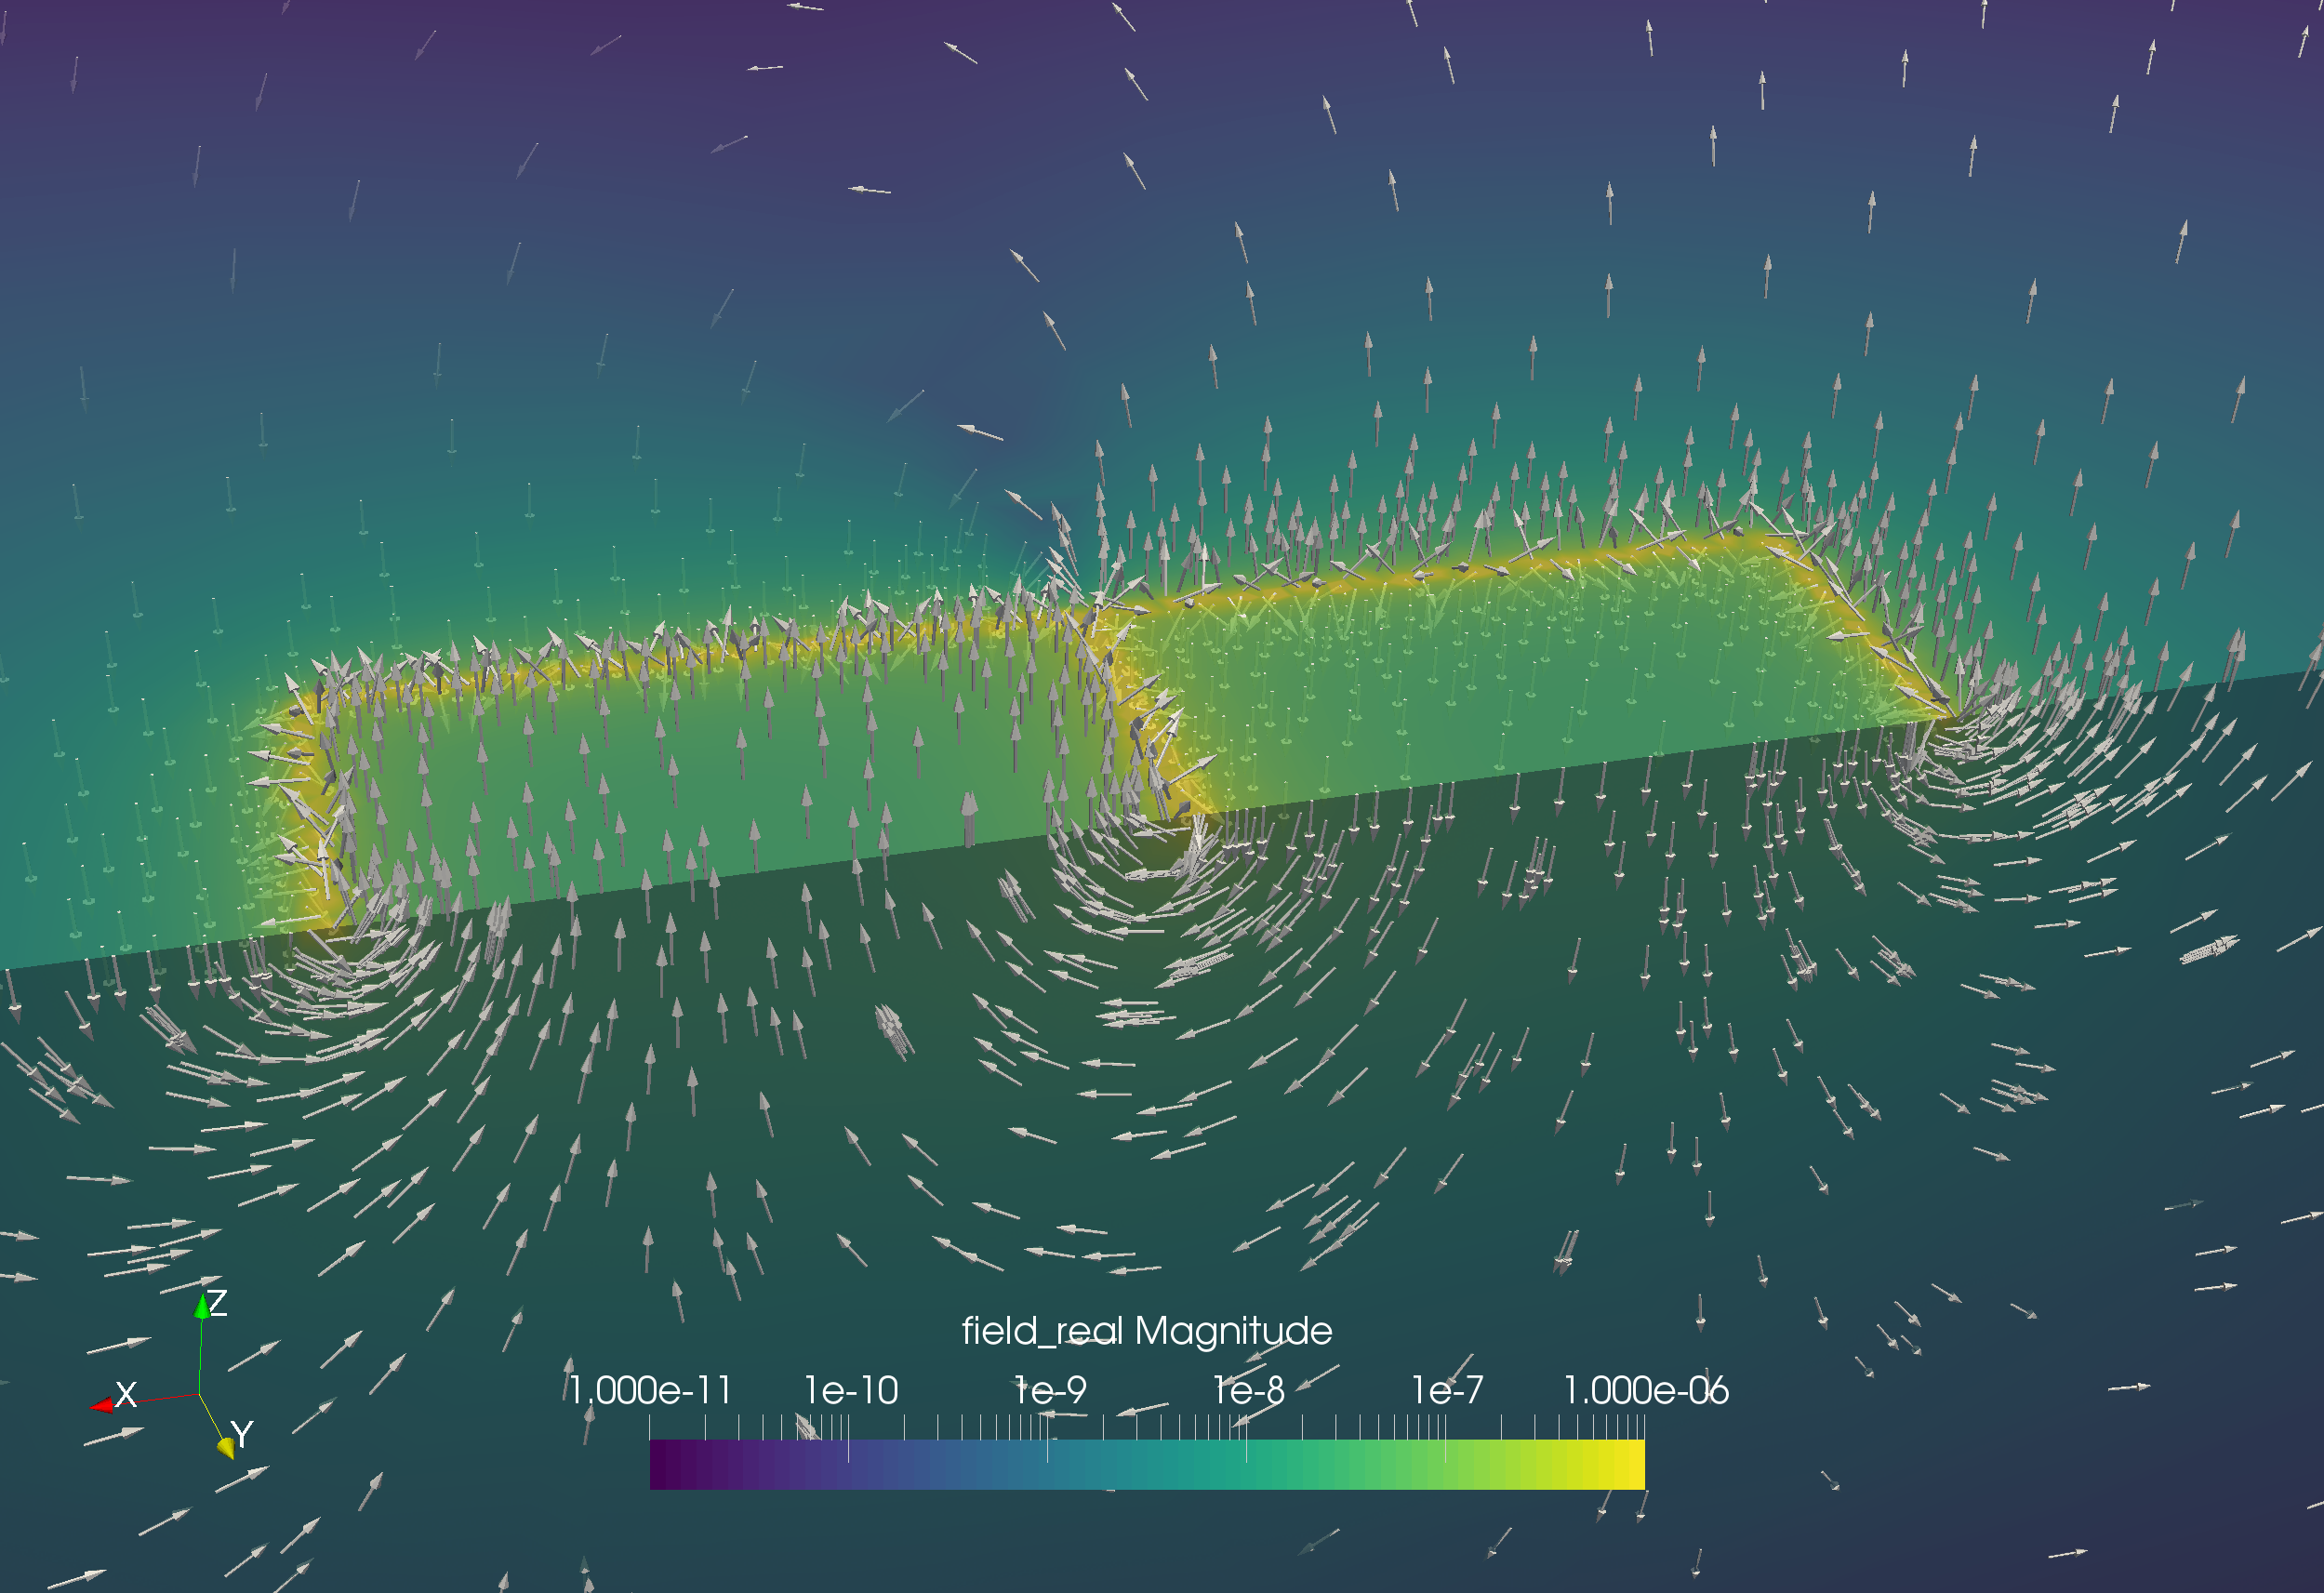